In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import pandas as pd 
import numpy as np
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
import os

In [2]:
import os

# Paths to the train and test directories
train_dir = r'C:\Users\Essam\Desktop\train'
test_dir = r'C:\Users\Essam\Desktop\test'

def count_images_in_subfolders(base_dir):
    counts = {}
    
    for subfolder in os.listdir(base_dir):
        subfolder_path = os.path.join(base_dir, subfolder)
        
        if os.path.isdir(subfolder_path):
            num_images = len(os.listdir(subfolder_path))
            counts[subfolder] = num_images
    
    return counts

# Count images in train and test directories
train_counts = count_images_in_subfolders(train_dir)
test_counts = count_images_in_subfolders(test_dir)

# Display the counts
print("Image counts in train folders:")
for subfolder, count in train_counts.items():
    print(f"{subfolder}: {count} images")

print("\nImage counts in test folders:")
for subfolder, count in test_counts.items():
    print(f"{subfolder}: {count} images")


Image counts in train folders:
0: 1951 images
1: 1954 images
2: 1949 images
3: 1930 images
4: 1917 images
5: 1885 images
6: 1882 images
7: 1879 images
8: 1860 images
9: 1819 images

Image counts in test folders:
0: 1301 images
1: 1303 images
2: 1300 images
3: 1288 images
4: 1278 images
5: 1257 images
6: 1255 images
7: 1253 images
8: 1241 images
9: 1213 images


In [3]:

# Paths to train and test directories
train_dir = r'C:\Users\Essam\Desktop\train'
test_dir = r'C:\Users\Essam\Desktop\test'

# Parameters
batch_size = 32
img_height = 224
img_width = 224

# Function to preprocess images
def preprocess_image(image, label):
    image = tf.image.resize(image, [img_height, img_width])
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image, label

# Load train and test datasets
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'  # Assuming the labels are integers (0-9)
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'
)

# Apply preprocessing
# Apply preprocessing and remove the extra batch operation
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)



Found 19026 files belonging to 10 classes.
Found 12689 files belonging to 10 classes.


In [4]:
checkpoint_dir = "model_checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_path = os.path.join(checkpoint_dir, "cp.weights.h5")
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=2,
                                                  restore_best_weights=True)

In [5]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
mixed_precision.global_policy()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


<Policy "mixed_float16">

In [6]:
# Define input shape
input_shape = (224, 224, 3)

# Load MobileNetV2 model without the top layer and freeze its weights
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
], name="data_augmentation")

# Input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Apply data augmentation
x = data_augmentation(inputs)

# Pass the augmented inputs to the MobileNetV2 base model
x = base_model(x, training=False)

# Global pooling layer
x = layers.GlobalAveragePooling2D()(x)

# Dense layer for the 10 classes
x = layers.Dense(10)(x)

# Softmax output
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

# Create the final model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Print the total layers in the base model and model summary
print(f"Total layers in the base model: {len(base_model.layers)}")

model.summary()


Total layers in the base model: 154
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
_________________________________________________________________
softmax_float32 (Activation) (None, 10)                0         
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
__________

In [7]:
history_feature_extraction = model.fit(train_data,
                                       epochs=20,
                                       steps_per_epoch=None,
                                       validation_data=test_data,
                                       validation_steps=None,
                                       callbacks=[model_checkpoint, early_stopping])

Epoch 1/20
595/595 [==============================] - 142s 162ms/step - loss: 0.7587 - accuracy: 0.7599 - val_loss: 0.4213 - val_accuracy: 0.8710
Epoch 2/20
595/595 [==============================] - 91s 100ms/step - loss: 0.4389 - accuracy: 0.8616 - val_loss: 0.3387 - val_accuracy: 0.8931
Epoch 3/20
595/595 [==============================] - 68s 82ms/step - loss: 0.3698 - accuracy: 0.8797 - val_loss: 0.3006 - val_accuracy: 0.9037
Epoch 4/20
595/595 [==============================] - 60s 81ms/step - loss: 0.3362 - accuracy: 0.8905 - val_loss: 0.2788 - val_accuracy: 0.9100
Epoch 5/20
595/595 [==============================] - 62s 79ms/step - loss: 0.3181 - accuracy: 0.8937 - val_loss: 0.2508 - val_accuracy: 0.9206
Epoch 6/20
595/595 [==============================] - 58s 75ms/step - loss: 0.2989 - accuracy: 0.9032 - val_loss: 0.2584 - val_accuracy: 0.9172
Epoch 7/20
595/595 [==============================] - 57s 76ms/step - loss: 0.2822 - accuracy: 0.9072 - val_loss: 0.2419 - val_accura

In [8]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

397/397 [==============================] - 14s 35ms/step - loss: 0.1919 - accuracy: 0.9374


[0.19193772971630096, 0.9374260902404785]

In [9]:
class_names = [str(i) for i in range(10)]

Precision: 0.9377
Recall: 0.9374
F1-Score: 0.9374


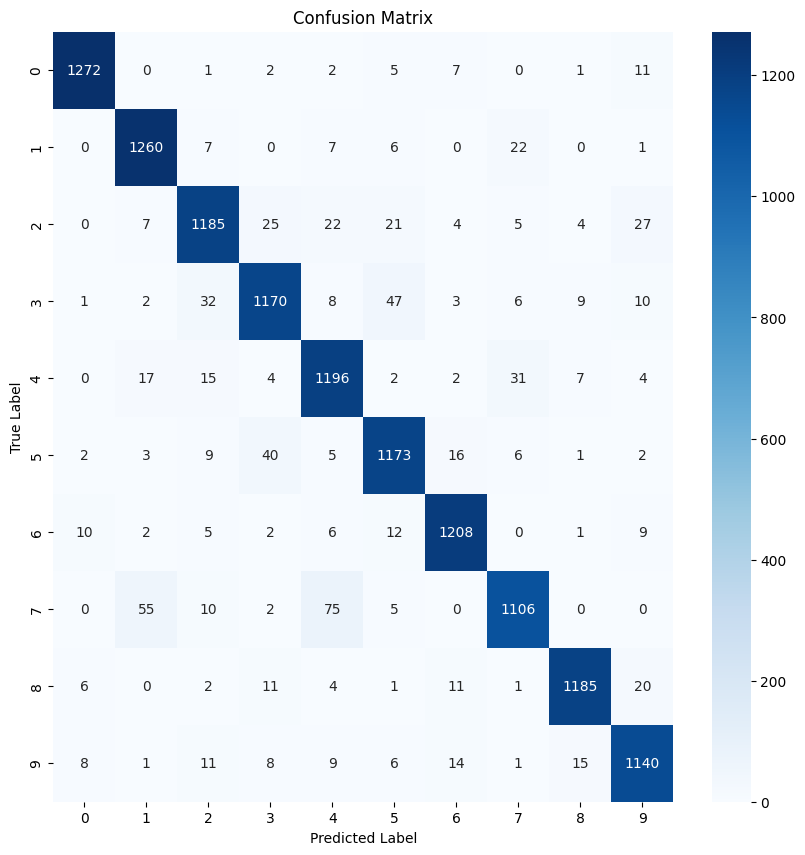

In [10]:
def calculate_metrics(model, test_data, class_names):
    y_true = []
    y_pred = []

    for images, labels in test_data:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(tf.argmax(preds, axis=1).numpy())

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-Score: {:.4f}".format(f1))    

    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    plt.figure(figsize=(10, 10))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=True, vmin=0, vmax=np.max(cm))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

calculate_metrics(model, test_data, class_names)

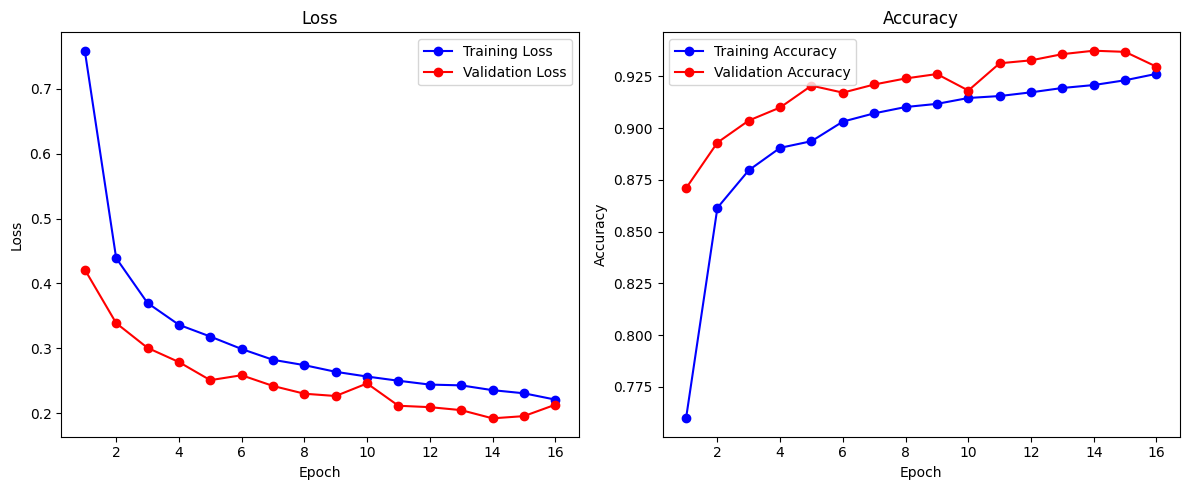

In [11]:
def plot_learning_curves(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_learning_curves(history_feature_extraction)

In [12]:
# Save the entire model after training
model.save('mobilenetv2_feature_extraction_model.h5')

c:\Users\Essam\anaconda3\envs\FCI\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [13]:
base_model.trainable = True

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=["accuracy"])

print(f"Total layers in the base model: {len(base_model.layers)}")

trainable_layers = len([layer for layer in base_model.layers if layer.trainable])
non_trainable_layers = len([layer for layer in base_model.layers if not layer.trainable])

print(f"Number of trainable layers: {trainable_layers}")
print(f"Number of non-trainable layers: {non_trainable_layers}")

model.summary()

Total layers in the base model: 154
Number of trainable layers: 54
Number of non-trainable layers: 100
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
_________________________________________________________________
softmax_float32 (Activation) (None, 10)                0         
Total params: 2,270,794


In [14]:
history_fine_tuning = model.fit(train_data,
                                epochs=20,
                                validation_data=test_data,
                                callbacks=[model_checkpoint, early_stopping])

Epoch 1/20
595/595 [==============================] - 88s 113ms/step - loss: 0.2241 - accuracy: 0.9220 - val_loss: 0.1515 - val_accuracy: 0.9522
Epoch 2/20
595/595 [==============================] - 77s 95ms/step - loss: 0.1768 - accuracy: 0.9403 - val_loss: 0.1273 - val_accuracy: 0.9587
Epoch 3/20
595/595 [==============================] - 59s 80ms/step - loss: 0.1455 - accuracy: 0.9497 - val_loss: 0.1360 - val_accuracy: 0.9574
Epoch 4/20
595/595 [==============================] - 62s 84ms/step - loss: 0.1282 - accuracy: 0.9564 - val_loss: 0.0962 - val_accuracy: 0.9691
Epoch 5/20
595/595 [==============================] - 65s 88ms/step - loss: 0.1181 - accuracy: 0.9604 - val_loss: 0.0883 - val_accuracy: 0.9710
Epoch 6/20
595/595 [==============================] - 64s 86ms/step - loss: 0.1045 - accuracy: 0.9637 - val_loss: 0.0958 - val_accuracy: 0.9673
Epoch 7/20
595/595 [==============================] - 61s 83ms/step - loss: 0.0908 - accuracy: 0.9691 - val_loss: 0.0767 - val_accuracy

In [15]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

397/397 [==============================] - 15s 37ms/step - loss: 0.0561 - accuracy: 0.9822


[0.056135233491659164, 0.9821892976760864]

Precision: 0.9825
Recall: 0.9822
F1-Score: 0.9822


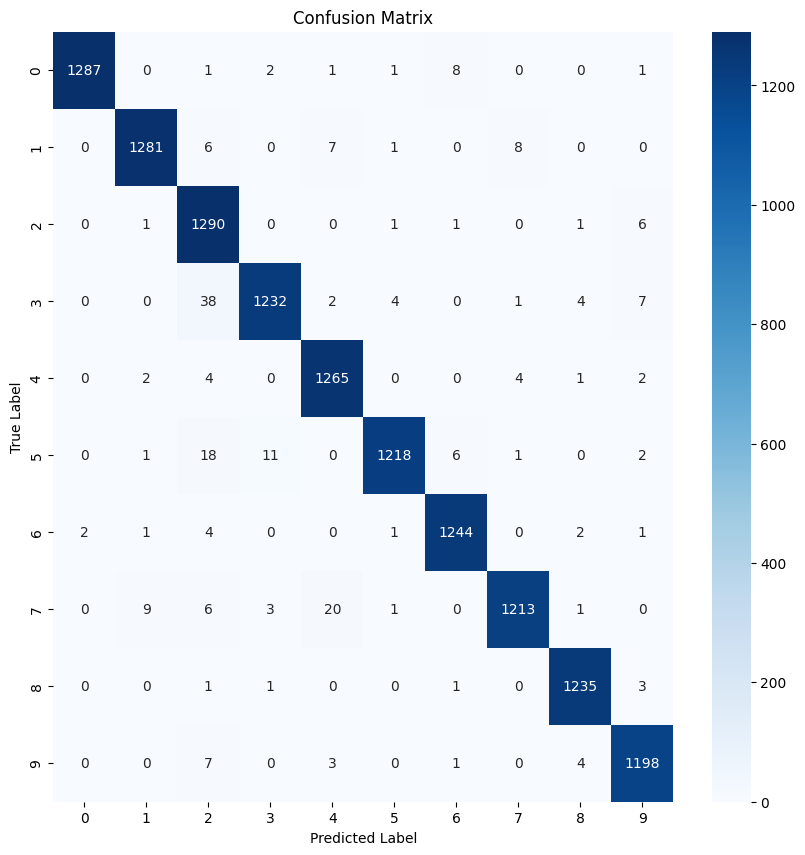

In [19]:
def calculate_metrics(model, test_data, class_names):
    y_true = []
    y_pred = []

    for images, labels in test_data:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(tf.argmax(preds, axis=1).numpy())

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-Score: {:.4f}".format(f1))    

    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    plt.figure(figsize=(10, 10))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=True, vmin=0, vmax=np.max(cm))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

calculate_metrics(model, test_data, class_names)

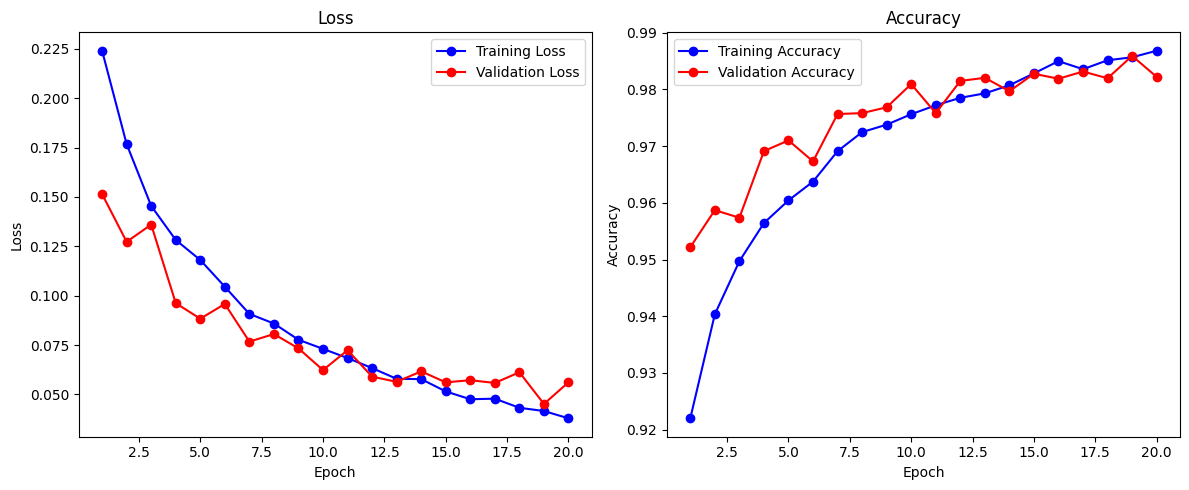

In [17]:
def plot_learning_curves(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.tight_layout()
    plt.show()


plot_learning_curves(history_fine_tuning)

In [18]:
# Save the entire model after training
model.save('mobilenetv2_feature_extraction_model11111.h5')

c:\Users\Essam\anaconda3\envs\FCI\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
